<a href="https://colab.research.google.com/github/MauroBuccoJr/pose-estimation/blob/main/notebooks/projeto_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Projeto Pose Estimation

Alunos: Mauro Giovani Bucco Junior e Pedro Antonio Guapo da Rocha

Na disciplina de Visão computacional com o professor Gustavo Benvenutti Borba, foi solicitado o desenvolvimento de uma rede neural convolucional capaz de determinar os pontos chaves (Keypoints) de uma imagem e realizar o pose estimation. Neste Colab desenvolvemos o passo a passo deste projeto, e exibimos validações e resultados do treinamento.

Primeiro, vamos obter o dataset LSP

Vamos ver qual é o diretório atual

In [ ]:
import os
print(os.getcwd()) #current work directory

/content


Execute o bloco abaixo e faça upload do token pessoal do kaggle (kaggle.json)

In [ ]:
from google.colab import files
files.upload() # clique no botão para carregar o json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"maurogb","key":"d3e4d6b12bf928665ce5d68fe7c54917"}'}

Vamos criar um diretório para armazenar o json do kaggle

In [ ]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


Vamos copiar o kaggle.json para o diretório que criamos anteriormente

In [ ]:
!cp kaggle.json ~/.kaggle/

Vamos alterar as permissões do json para read only

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

Finalmente, vamos baixar o dataset LSP -

In [ ]:
!kaggle datasets download -d dkrivosic/leeds-sports-pose-lsp
!ls /content/*.zip # inspecionando

Dataset URL: https://www.kaggle.com/datasets/dkrivosic/leeds-sports-pose-lsp
License(s): unknown
  0% 0.00/33.8M [00:00<?, ?B/s]
100% 33.8M/33.8M [00:00<00:00, 1.37GB/s]
/content/leeds-sports-pose-lsp.zip


Vamos descompactar o dataset

In [ ]:
!unzip -qq leeds-sports-pose-lsp.zip
!ls /content/*.zip # inspecionando

/content/leeds-sports-pose-lsp.zip


O dataset utilizado está organizado desse jeito:

images/ - Pasta que contém 1000 imagens para o treinamento, com nomes do tipo "im0001".jpg

visualized/ - Pasta que contém as mesmas 1000 imagens, mas com os keypoints desenhados na imagem

joints.mat - Arquivo que contém, para cada imagem, um conjunto de 14 keipoints descritos por suas coordenadas x, y e pela visibilidade

Primeiro, vamos ler os valores de joints.mat

Para isso, já vamos importar as bibliotecas necessárias para o posterior treinamento

In [29]:
!pip install scipy opencv-python tensorflow

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image
from scipy.io import loadmat
import random

Agora sim, vamos ler o arquivo joints.mat

In [ ]:
joints_raw = loadmat('joints.mat')['joints']  # shape: (3, 14, 2000)

print(joints_raw[1])

# Remove visibilidade, deixa só x, y (0 e 1)
joints_xy = joints_raw[:2]                    # shape: (2, 14, 2000)

# Transpõe para (imagem, keypoint, coord)
joints = joints_xy.transpose(2, 1, 0)         # shape: (2000, 14, 2)                     # (14, 2)

print(joints[1])

[[143.34544031 166.65510177  81.76862604 ... 122.67616262 143.63021477
  174.13600322]
 [117.22690013 136.64584985  50.39045779 ...  98.37141354 111.36130084
  138.4885341 ]
 [ 84.67918082  95.84379681  68.90357705 ... 101.26483605  81.78146308
  105.58317799]
 ...
 [ 58.96246433  96.37027491  96.35947427 ...  38.95980467  84.47053924
   11.89431685]
 [ 36.05851371  52.6725923   51.33180284 ...  48.79744121  32.03355411
   50.28389898]
 [ 15.56550525  30.82375099  29.68086674 ...  34.71611833  14.55455907
   39.31544694]]
[[ 28.12031897 166.65510177]
 [ 49.17944312 136.64584985]
 [ 62.60463477  95.84379681]
 [ 80.24165125  96.10703586]
 [ 91.56093048 130.85459071]
 [ 78.39897788 142.70034805]
 [ 61.28843951  78.99649749]
 [ 49.96916028  73.73171645]
 [ 63.92083003  50.56667988]
 [ 98.66838488  53.46230945]
 [111.30385937  69.78313067]
 [109.46118601  96.37027491]
 [ 81.0313684   52.6725923 ]
 [ 83.40051987  30.82375099]]


Vamos organizar o dataset em três partes: treino, validação e teste

In [ ]:
from sklearn.model_selection import train_test_split

idx = np.arange(2000)
train_idx, test_idx = train_test_split(idx, test_size=0.1, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.05, random_state=42)  # 5% da parte de treino

print(len(train_idx), "treino")
print(len(val_idx), "validação")
print(len(test_idx), "teste")

1710 treino
90 validação
200 teste


Vamos definir uma função para ler as imagens e os keypoints correspondentes

Note que vamos preprocessar as imagens, pois precisamos que elas tenham tamanho 256x256x3 (RGB). O mesmo se aplica aos keypoints, que originalmente estão representados em coordenadas absolutas das imagens

In [ ]:
def load_image_keypoints(idx, img_dir='images', target_size=(256, 256)):
    img_path = os.path.join(img_dir, f'im{idx+1:04d}.jpg')
    img = Image.open(img_path).convert('RGB')

    orig_w, orig_h = img.size
    #print(f"{orig_w=}{orig_h=}")
    img = img.resize(target_size)
    img_np = np.array(img) / 255.0  # Normaliza imagem

    keypoints = joints[idx].copy()  # (14, 2)
    #print(f"{keypoints=}")

    keypoints[:, 0] = keypoints[:, 0] / orig_w * 256
    keypoints[:, 1] = keypoints[:, 1] / orig_h * 256

    return img_np, keypoints  # keypoints em coordenadas absolutas (ex: 256×256)

Agora, precisamos gerar os heatmaps através dos keypoints

Como o LSP trabalha com as coordenadas (x, y) dos pontos, precisamos criar uma função para gerar os heatmaps a partir desses dados

In [ ]:
def generate_heatmaps(keypoints, height=64, width=64, sigma=2):
    heatmaps = np.zeros((height, width, keypoints.shape[0]), dtype=np.float32)

    for i, (x, y) in enumerate(keypoints):
        if x < 0 or y < 0:
            continue

        # Reduz coordenadas de 256x256 para 64x64
        x = x / 256 * width
        y = y / 256 * height

        xx, yy = np.meshgrid(np.arange(width), np.arange(height))
        heatmap = np.exp(-((xx - x)**2 + (yy - y)**2) / (2 * sigma**2))

        heatmap /= np.max(heatmap)  # Normaliza para 1
        heatmaps[..., i] = heatmap

    return heatmaps



Agora, vamos criar uma função que retorna a imagem e um heatmap, utilizando o índice da imagem no dataset

In [ ]:
def preprocess_example(idx):
    image, keypoints = load_image_keypoints(idx)
    heatmaps = generate_heatmaps(keypoints)
    return image.astype(np.float32), heatmaps.astype(np.float32)

Função para visualizar os heatmaps

Keypoints recuperados dos heatmaps:


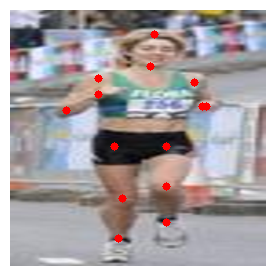

Keypoints originais do dataset:


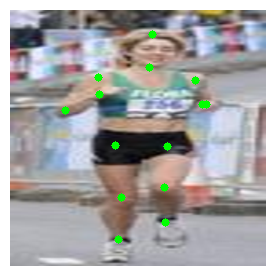

Heatmaps gerados:


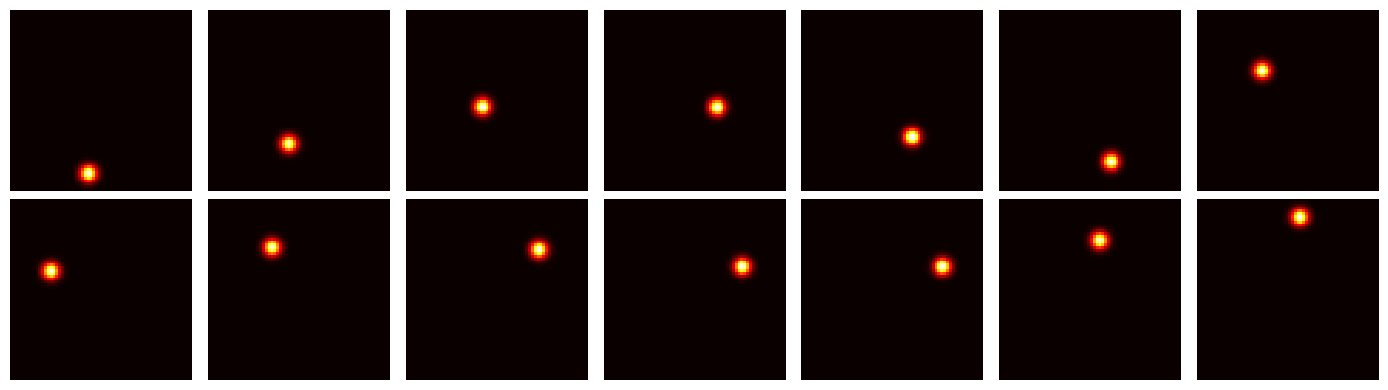

In [ ]:
def get_keypoints_from_heatmaps(heatmaps):
    keypoints = []
    for i in range(heatmaps.shape[-1]):
        hmap = heatmaps[..., i]
        y, x = np.unravel_index(np.argmax(hmap), hmap.shape)
        keypoints.append((x, y))  # Escala (64 -> 256)
    return keypoints

def show_image_with_keypoints(img, heatmaps):
    keypoints = get_keypoints_from_heatmaps(heatmaps)
    img = (img * 255).astype(np.uint8).copy()
    for x, y in keypoints:
        x_ = x * 4
        y_ = y * 4
        cv2.circle(img, (x_, y_), 4, (255, 0, 0), -1)
    plt.figure(figsize=(2.56, 2.56), dpi=100)
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

def show_image_with_true_keypoints(img, keypoints):
    img_vis = (img * 255).astype(np.uint8).copy()
    for x, y in keypoints:
        x_, y_ = int(x), int(y)
        cv2.circle(img_vis, (x_, y_), 4, (0, 255, 0), -1)  # verde para ground truth
    plt.figure(figsize=(2.56, 2.56), dpi=100)
    plt.imshow(img_vis)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

def show_heatmaps(heatmaps, ground_truth=None, size=(64, 64), titles=None):
    num_keypoints = heatmaps.shape[-1]
    cols = 7
    rows = int(np.ceil(num_keypoints / cols))

    plt.figure(figsize=(cols * 2, rows * 2))
    for i in range(num_keypoints):
        plt.subplot(rows, cols, i + 1)
        if ground_truth is not None:
            plt.imshow(ground_truth[..., i], cmap='gray', alpha=0.5)
        plt.imshow(heatmaps[..., i], cmap='hot', interpolation='nearest')
        if titles:
            plt.title(titles[i], fontsize=8)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


# Visualizar
img_idx = 0
img, hmaps_gt = preprocess_example(img_idx)
print("Keypoints recuperados dos heatmaps:")
show_image_with_keypoints(img, hmaps_gt)
img, keypoints = load_image_keypoints(0)
print("Keypoints originais do dataset:")
show_image_with_true_keypoints(img, keypoints)
print("Heatmaps gerados:")
show_heatmaps(hmaps_gt)

Precisamos criar um gerador que extraia os conjuntos de imagens e heatmaps para cada dataset

In [ ]:
def val_generator():
  for i in val_idx:
    yield preprocess_example(i)

def train_generator():
  for i in train_idx:
    yield preprocess_example(i)

def test_generator():
    for i in test_idx:
        yield preprocess_example(i)

Vamos criar os nossos datasets de treinamento, validação e teste

In [ ]:
train_dataset = tf.data.Dataset.from_generator(
    train_generator,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(64, 64, 14), dtype=tf.float32)
    )
).repeat().batch(12).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(
    test_generator,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(64, 64, 14), dtype=tf.float32)
    )
).repeat().batch(12).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    val_generator,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(64, 64, 14), dtype=tf.float32)
    )
).repeat().batch(12).prefetch(tf.data.AUTOTUNE)

Vamos verificar as dimensões do nosso dataset

In [56]:
for img, hmap in train_dataset.take(1):
    print(img.shape, hmap.shape)  # Esperado: (12, 256, 256, 3), (12, 64, 64, 14)

(12, 256, 256, 3) (12, 64, 64, 14)


Finalmente, vamos definir como será a nossa rede

O backbone utilizado é a MobileNetV2, com algumas layers adicionais

A MobileNetV2 não será treinada novamente, ao invés disso será utilizada apenas para extrair as features mais abstratas. Essa técnica é denominada transfer learning

In [ ]:
def build_pose_model(input_shape=(256, 256, 3), num_keypoints=14):
    base = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base.trainable = False # isso garante que os pesos originais não serão alterados

    x = base.output  # (8, 8, 1280)

    x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D()(x)  # 16x16

    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D()(x)  # 32x32

    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D()(x)  # 64x64

    x = layers.Conv2D(num_keypoints, 1, activation='sigmoid')(x)  # (64, 64, 14)

    return models.Model(inputs=base.input, outputs=x)

Vamos adicionar um callback para visualizar as imagens durante o treinamento

In [30]:
def get_keypoints_from_heatmaps(heatmaps):
    keypoints = []
    for i in range(heatmaps.shape[-1]):
        hmap = heatmaps[..., i]
        y, x = np.unravel_index(np.argmax(hmap), hmap.shape)
        keypoints.append((x, y))  # Escala (64 -> 256)
    return keypoints

def show_image_with_keypoints(img, heatmaps):
    keypoints = get_keypoints_from_heatmaps(heatmaps)
    img = (img * 255).astype(np.uint8).copy()
    for x, y in keypoints:
        x_ = x * 4
        y_ = y * 4
        cv2.circle(img, (x_, y_), 4, (255, 0, 0), -1)
    plt.figure(figsize=(2.56, 2.56), dpi=100)
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

# from IPython.display import clear_output
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    if epoch%2 == 0:
      test_img, keypoints = load_image_keypoints(0)
      pred = model.predict(np.expand_dims(test_img, axis=0))[0]
      show_image_with_keypoints(test_img, pred)

Agora sim, podemos criar nosso model, e iniciar o treinamento

/tmp/ipython-input-19-888604016.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')


Epoch 1/16
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


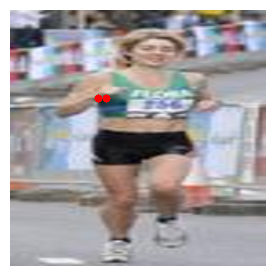

142/142 ━━━━━━━━━━━━━━━━━━━━ 32s 144ms/step - loss: 191.1184 - val_loss: 187.5075
Epoch 2/16
142/142 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - loss: 226.1465 - val_loss: 289.6998
Epoch 3/16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


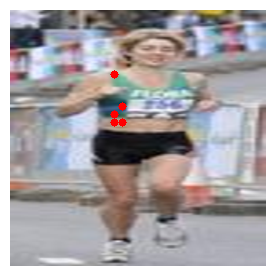

142/142 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - loss: 174.7702 - val_loss: 154.2968
Epoch 4/16
142/142 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - loss: 138.8765 - val_loss: 73.7934
Epoch 5/16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


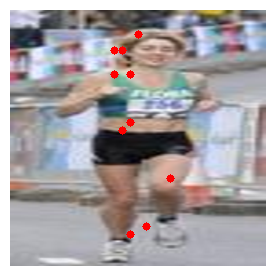

142/142 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - loss: 71.5592 - val_loss: 62.3475
Epoch 6/16
142/142 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - loss: 57.6242 - val_loss: 60.3789
Epoch 7/16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


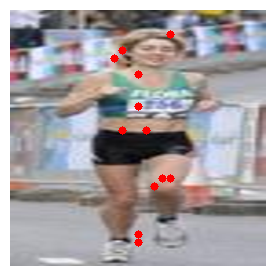

142/142 ━━━━━━━━━━━━━━━━━━━━ 20s 143ms/step - loss: 58.8903 - val_loss: 93.1035
Epoch 8/16
142/142 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - loss: 54.2816 - val_loss: 56.9393
Epoch 9/16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


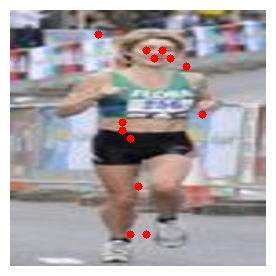

142/142 ━━━━━━━━━━━━━━━━━━━━ 20s 143ms/step - loss: 58.0551 - val_loss: 58.3407
Epoch 10/16
142/142 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - loss: 53.7048 - val_loss: 55.4375
Epoch 11/16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


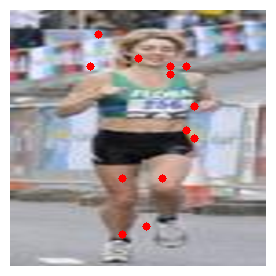

142/142 ━━━━━━━━━━━━━━━━━━━━ 12s 88ms/step - loss: 55.9206 - val_loss: 58.1696
Epoch 12/16
142/142 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step - loss: 52.2639 - val_loss: 56.9852
Epoch 13/16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


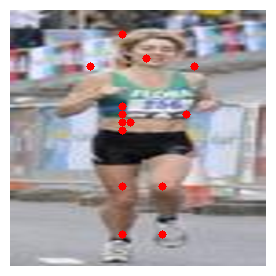

142/142 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - loss: 51.9870 - val_loss: 56.6602
Epoch 14/16
142/142 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - loss: 51.6810 - val_loss: 60.3720
Epoch 15/16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


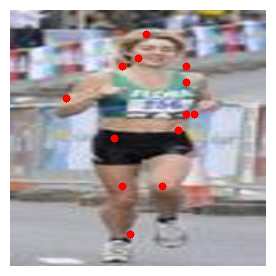

142/142 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - loss: 51.7764 - val_loss: 60.5233
Epoch 16/16
142/142 ━━━━━━━━━━━━━━━━━━━━ 12s 88ms/step - loss: 51.0787 - val_loss: 57.6560


In [32]:
def heatmap_mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def get_keypoints(hmaps):
    h = tf.shape(hmaps)[1]
    w = tf.shape(hmaps)[2]
    hmaps_flat = tf.reshape(hmaps, (-1, tf.cast(h * w, tf.int64), tf.shape(hmaps)[-1]))
    idxs = tf.argmax(hmaps_flat, axis=1)  # (batch, 14)
    x = tf.math.floormod(idxs, tf.cast(w, tf.int64))
    y = tf.math.floordiv(idxs, tf.cast(w, tf.int64))
    return tf.cast(tf.stack([x, y], axis=-1), tf.float32)  # (batch, 14, 2)

def coord_mse_loss(y_true, y_pred):
    kp_true = get_keypoints(y_true)
    kp_pred = get_keypoints(y_pred)
    return tf.reduce_mean(tf.square(kp_true - kp_pred))

def hybrid_loss(y_true, y_pred, alpha=0.5):
    return alpha * heatmap_mse(y_true, y_pred) + (1 - alpha) * coord_mse_loss(y_true, y_pred)

model = build_pose_model()
model.compile(optimizer='adam', loss=hybrid_loss)

# Hiperparâmetros do treinamento
num_train = len(train_idx)
batch_size = 12
# originalmente 20
epochs = 16
steps_per_epoch = num_train // batch_size
validation_steps = len(val_idx) // batch_size

model_history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=epochs,
    callbacks=[DisplayCallback()]
)

Vamos testar nossa rede

In [35]:
from enum import Enum

class Keypoints(Enum):
    RIGHT_ANKLE = 0
    RIGHT_KNEE = 1
    RIGHT_HIP = 2
    LEFT_HIP = 3
    LEFT_KNEE = 4
    LEFT_ANKLE = 5
    RIGHT_WRIST = 6
    RIGHT_ELBOW = 7
    RIGHT_SHOULDER = 8
    LEFT_SHOULDER = 9
    LEFT_ELBOW = 10
    LEFT_WRIST = 11
    NECK = 12
    HEAD_TOP = 13

skeleton_lines = [(Keypoints.RIGHT_ANKLE.value, Keypoints.RIGHT_KNEE.value),
                  (Keypoints.RIGHT_KNEE.value, Keypoints.RIGHT_HIP.value),
                  (Keypoints.LEFT_HIP.value, Keypoints.LEFT_KNEE.value),
                  (Keypoints.LEFT_HIP.value, Keypoints.RIGHT_HIP.value),
                  (Keypoints.LEFT_KNEE.value, Keypoints.LEFT_ANKLE.value),
                  (Keypoints.RIGHT_WRIST.value, Keypoints.RIGHT_ELBOW.value),
                  (Keypoints.RIGHT_ELBOW.value, Keypoints.RIGHT_SHOULDER.value),
                  (Keypoints.LEFT_SHOULDER.value, Keypoints.LEFT_ELBOW.value),
                  (Keypoints.LEFT_ELBOW.value, Keypoints.LEFT_WRIST.value),
                  (Keypoints.RIGHT_SHOULDER.value, Keypoints.NECK.value),
                  (Keypoints.LEFT_SHOULDER.value, Keypoints.NECK.value),
                  (Keypoints.NECK.value, Keypoints.HEAD_TOP.value),
                  (Keypoints.LEFT_HIP.value, Keypoints.NECK.value),
                  (Keypoints.RIGHT_HIP.value, Keypoints.NECK.value)]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predição do modelo:


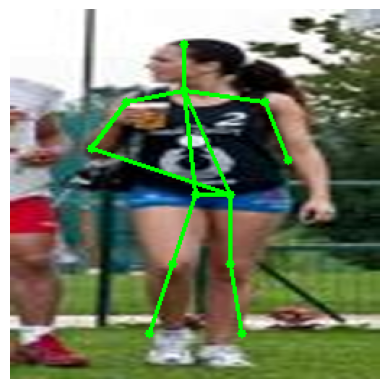

Ground truth:


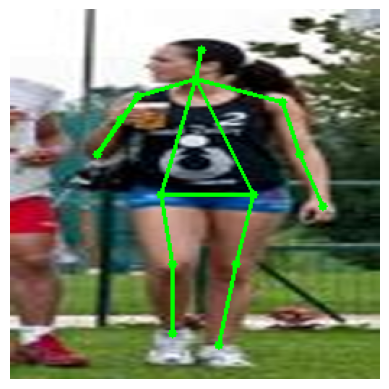

Heatmaps gerados pelo modelo:


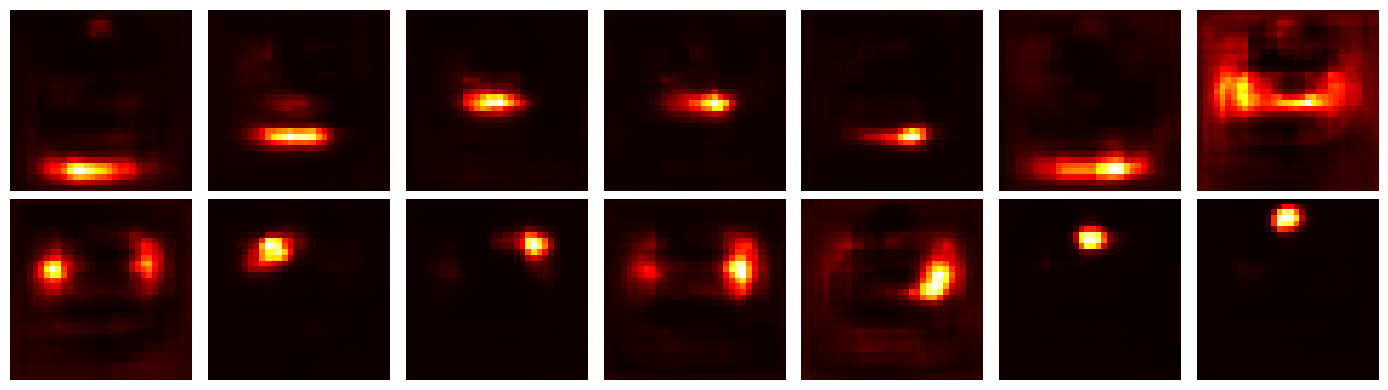

Heatmaps verdadeiros:


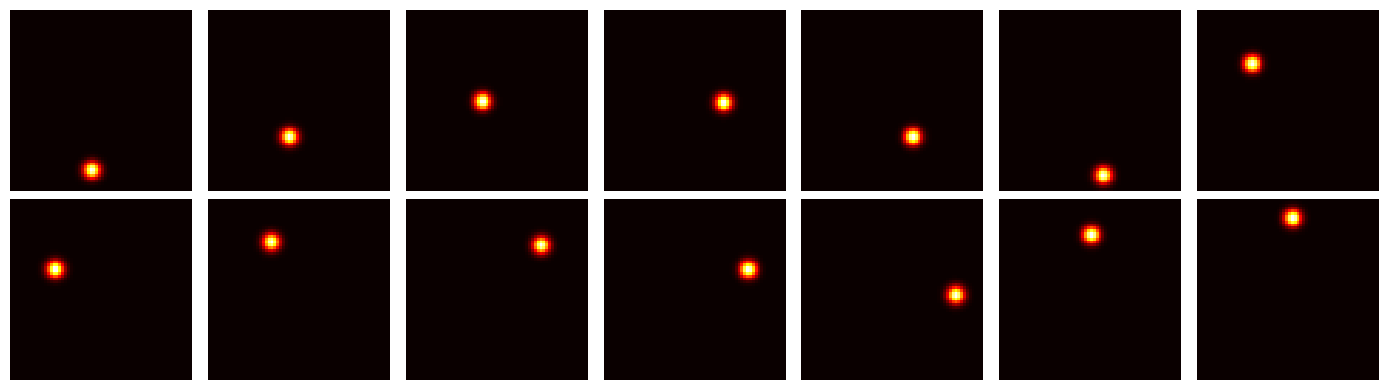

In [51]:
def get_keypoints_from_heatmaps(heatmaps):
    keypoints = []
    for i in range(heatmaps.shape[-1]):
        hmap = heatmaps[..., i]
        y, x = np.unravel_index(np.argmax(hmap), hmap.shape)
        keypoints.append((x, y))
    return keypoints

def visualize_prediction(img, heatmaps):
    img = (img * 255).astype(np.uint8)
    keypoints = get_keypoints_from_heatmaps(heatmaps)
    for x, y in keypoints:
        cv2.circle(img, (x*4, y*4), 3, (0, 255, 0), -1)

    for line in skeleton_lines:
        x1, y1 = keypoints[line[0]]
        x2, y2 = keypoints[line[1]]
        cv2.line(img, (x1 * 4, y1 * 4), (x2 * 4, y2 * 4), (0, 255, 0), 2)

    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Teste com uma imagem do dataset
test_img, keypoints = load_image_keypoints(random.choice(test_idx)) # escolhe uma imagem aleatória do dataset de teste
pred = model.predict(np.expand_dims(test_img, axis=0))[0]
print("Predição do modelo:")
visualize_prediction(test_img, pred)
original_heatmaps = generate_heatmaps(keypoints)
print("Ground truth:")
visualize_prediction(test_img, original_heatmaps)

print("Heatmaps gerados pelo modelo:")
show_heatmaps(pred)
print("Heatmaps verdadeiros:")
show_heatmaps(original_heatmaps)

#visualize_prediction(test_img, keypoints)


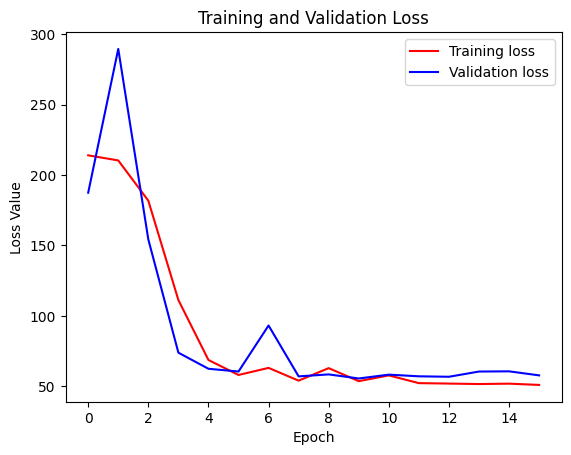

In [43]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs_range = range(epochs)

plt.figure()
plt.plot(epochs_range, loss, 'r', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
#plt.ylim([0, 1]) # Commented out to see the full loss range
plt.legend()
plt.show()

Vamos testar o nosso modelo com imagens que não estão no dataset

In [44]:
!mkdir demo

Agora, basta fazer upload das imagens dentro da pasta demo.

Rodar Demonstração da Rede Neural

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


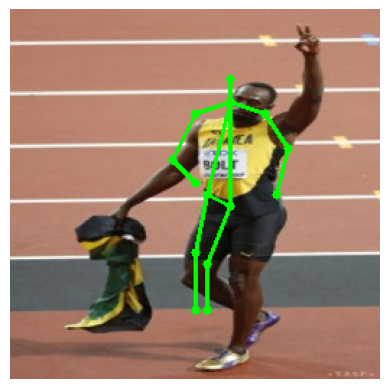

In [58]:
# Demonstração do nosso modelo com uma imagem

def load_image(nome, img_dir='demo', target_size=(256, 256)):
    img_path = os.path.join(img_dir, f'{nome}.jpg') # precisa ser jpg
    img = Image.open(img_path).convert('RGB')

    orig_w, orig_h = img.size
    img = img.resize(target_size)
    img_np = np.array(img) / 255.0  # Normaliza imagem

    return img_np

test_img = load_image('bolt') # mude o nome da imagem para o nome do arquivo desejado
pred = model.predict(np.expand_dims(test_img, axis=0))[0]
visualize_prediction(test_img, pred)

#test_img = load_image('usain')
#pred = model.predict(np.expand_dims(test_img, axis=0))[0]
#visualize_prediction(test_img, pred)

#test_img = load_image('ronaldo')
#pred = model.predict(np.expand_dims(test_img, axis=0))[0]
#visualize_prediction(test_img, pred)
